In [26]:
import torch
import torchvision
from torchvision import datasets, transforms

In [27]:
# Loading in images

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

train_data_path = '/Users/janet/Desktop/2nd Year - UCLA/winter24/DSU Project/brain_tumor_dataset/train'
val_data_path = '/Users/janet/Desktop/2nd Year - UCLA/winter24/DSU Project/brain_tumor_dataset/val'
test_data_path = '/Users/janet/Desktop/2nd Year - UCLA/winter24/DSU Project/brain_tumor_dataset/test'

train_data = datasets.ImageFolder(train_data_path, transform=transform)
val_data = datasets.ImageFolder(val_data_path, transform=transform)
test_data = datasets.ImageFolder(test_data_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

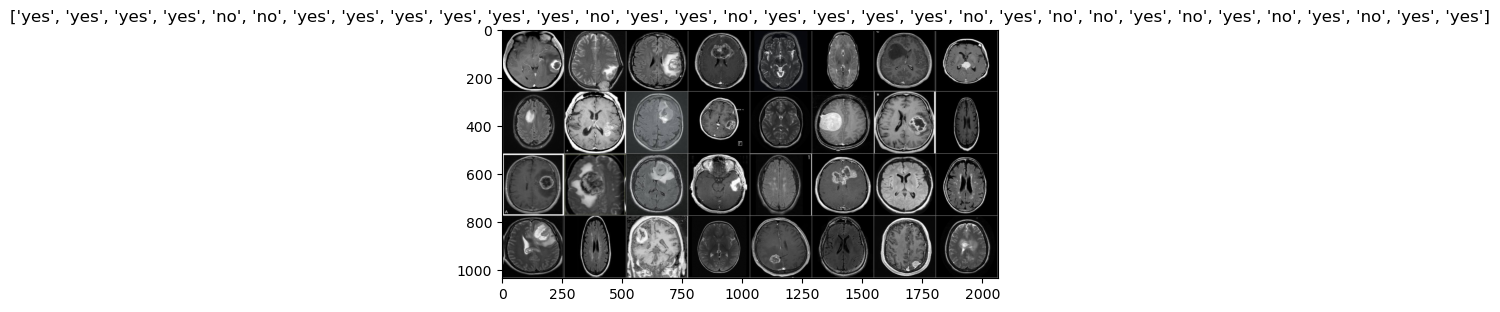

In [28]:
# checking that images loaded in correctly

import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataiter = iter(train_loader)
images, labels = next(dataiter)

out = torchvision.utils.make_grid(images)

imshow(out, title=[train_data.classes[x] for x in labels])

In [29]:
# defining my cnn model

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # For RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # connect layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Make sure the input size is correct
        self.fc2 = nn.Linear(512, 2)  # Assuming binary classification (tumor / no tumor)
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        # relu -> conv -> pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten -> connected layer
        x = x.view(-1, 128 * 32 * 32)
        
        # connected layer with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # output layer
        x = self.fc2(x)
        return x


In [30]:
# Create the CNN model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [31]:
# defining loss and optimizer functions

import torch.optim as optim

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer (using Adam as an example)
optimizer = optim.Adam(model.parameters(), lr=0.001) # model.parameters() so it knows which params to update

# You can also specify additional options for the optimizer:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# lr = learning rate

In [32]:
# first training loop

# Example training loop for one epoch
for epoch in range(20):
    
    
    
    
    
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # compute loss
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        
        # optimize he weights
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [33]:
# validation loop

# set model to eval mode
model.eval()

# track validation loss
valid_loss = 0.0
correct = 0
total = 0

# deactivate autograd for evaluation
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        
        # forward pass
        outputs = model(images)
        
        # calc batch loss
        loss = criterion(outputs, labels)
        
        
        # update total validation loss
        valid_loss += loss.item()
        
        
        # calc accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calc avg losses
valid_loss = valid_loss / len(val_loader.dataset)

# Calculate accuracy
accuracy = correct / total

print(f'Validation Loss: {valid_loss:.6f}, Validation Accuracy: {accuracy:.2f}%')

Validation Loss: 0.108498, Validation Accuracy: 0.78%


In [34]:
# testing

# Set the model to evaluation mode
model.eval()

# To track the test loss
test_loss = 0.0
correct = 0
total = 0

# Deactivate autograd for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Forward pass
        outputs = model(images)
        # Calculate the batch loss
        loss = criterion(outputs, labels)
        # Update total test loss
        test_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average losses
test_loss = test_loss / len(test_loader.dataset)

# Calculate accuracy
accuracy = correct / total * 100

print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.031057, Test Accuracy: 77.78%


In [ ]:
# testing

# Set the model to evaluation mode
model.eval()

# To track the test loss
test_loss = 0.0
correct = 0
total = 0

# Deactivate autograd for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Forward pass
        outputs = model(images)
        # Calculate the batch loss
        loss = criterion(outputs, labels)
        # Update total test loss
        test_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average losses
test_loss = test_loss / len(test_loader.dataset)

# Calculate accuracy
accuracy = correct / total * 100

print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {accuracy:.2f}%')

In [38]:
graph_model = SimpleCNN()

Epoch 1, Train Accuracy: 0.51, Validation Accuracy: 0.54
Epoch 2, Train Accuracy: 0.47, Validation Accuracy: 0.54
Epoch 3, Train Accuracy: 0.52, Validation Accuracy: 0.54
Epoch 4, Train Accuracy: 0.52, Validation Accuracy: 0.54
Epoch 5, Train Accuracy: 0.53, Validation Accuracy: 0.54
Epoch 6, Train Accuracy: 0.46, Validation Accuracy: 0.54
Epoch 7, Train Accuracy: 0.56, Validation Accuracy: 0.54
Epoch 8, Train Accuracy: 0.49, Validation Accuracy: 0.54
Epoch 9, Train Accuracy: 0.52, Validation Accuracy: 0.54
Epoch 10, Train Accuracy: 0.49, Validation Accuracy: 0.54
Epoch 11, Train Accuracy: 0.48, Validation Accuracy: 0.54
Epoch 12, Train Accuracy: 0.52, Validation Accuracy: 0.54
Epoch 13, Train Accuracy: 0.44, Validation Accuracy: 0.54
Epoch 14, Train Accuracy: 0.46, Validation Accuracy: 0.54
Epoch 15, Train Accuracy: 0.51, Validation Accuracy: 0.54
Epoch 16, Train Accuracy: 0.53, Validation Accuracy: 0.54
Epoch 17, Train Accuracy: 0.57, Validation Accuracy: 0.54
Epoch 18, Train Accurac

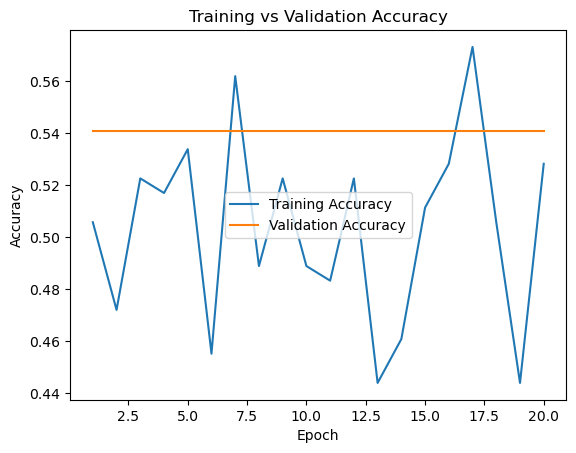

In [39]:
import matplotlib.pyplot as plt

# Lists to keep track of accuracy and loss
train_accuracies = []
valid_accuracies = []

for epoch in range(20):  # Assume you are training for 20 epochs
    
    # For training
    graph_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = graph_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # For validation
    graph_model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = graph_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = correct_val / total_val
    valid_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}')

# Plotting the training and validation accuracy
plt.plot(range(1, 21), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 21), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [36]:
# Save the model checkpoint
torch.save(model.state_dict(), 'brain_tumor_detector.pth')